# Dimensionality Reduction Evaluation
C. Heiser, 2019

---
__The purpose of this notebook is to evaluate dimensionality reduction techniques for their ability to preserve Euclidean structure of high-dimensional datasets.__  
  
To benchmark these techniques, we are using two single-cell RNAseq datasets:
* From [__Macosko, *et al* (2015)__](https://www.ncbi.nlm.nih.gov/pubmed/26000488), the mouse retina scRNA-seq data generated using DropSeq: [GSM1626793](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM1626793)
* From [__Herring, *et al* (2018)__](https://www.ncbi.nlm.nih.gov/pubmed/29153838), the WT mouse colon scRNA-seq data generated using inDrops: [GSM2743164](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM2743164)  
  
The first set should be __discrete__, containing highly separable cell populations from the mouse retina, where the latter will be __continuous__, representing a continuum of branching cell states in the gut epithelium.  
  
Both datasets have been __preprocessed and feature-selected__ to allow for direct input to downstream dimensionality reduction algorithms (rather than first performing PCA to limit dimensional input). These methods are shown in [`dev/QC.ipynb`](dev/QC.ipynb) and [`dev/preprocess_and_filter.ipynb`](dev/preprocess_and_filter.ipynb).

In [1]:
from fcc_DRs import *
%matplotlib inline

In [2]:
# read in Macosko retina data
retina = RNA_counts.from_file('inputs/GSM1626793_P14Retina_1.processed.tsv', cells_axis=0, labels=[0,0])
# read in Herring colon data
colon = RNA_counts.from_file('inputs/GSM2743164_rep1_colon_rnaseq.processed.tsv', cells_axis=0, labels=[0,0])

In [3]:
# look at dimensions of counts matrix (cells, genes)
retina.data.shape

(1652, 500)

In [4]:
# look at dimensions of counts matrix (cells, genes)
colon.data.shape

(1653, 500)

---
### PCA
We'll look at principal component analysis (PCA) first, as a gold-standard. Because PCA performs a __linear__ transformation on the data, 500 PCs should perfectly preserve the overall dataset structure.

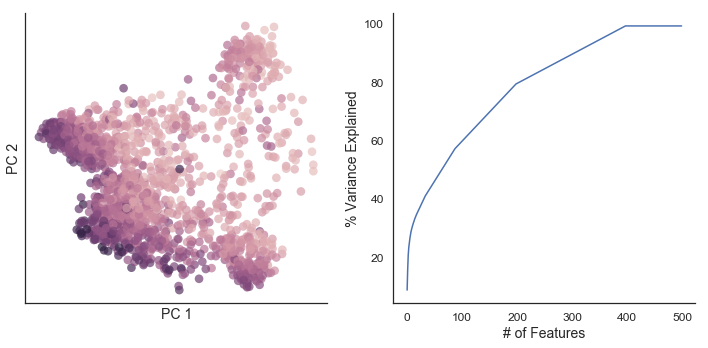

In [178]:
retina_PCA500 = fcc_PCA(retina.arcsinh_norm(), n_components=500)
retina_PCA500.plot_PCA()

We can test the Euclidean distance preservation as follows:

In [14]:
# choose value for K-nearest neighbor calculations. We use 30 because that is the standard perplexity chosen for DR techniques here.
k = 30

/Users/cody/.virtualenvs/lau_lab/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


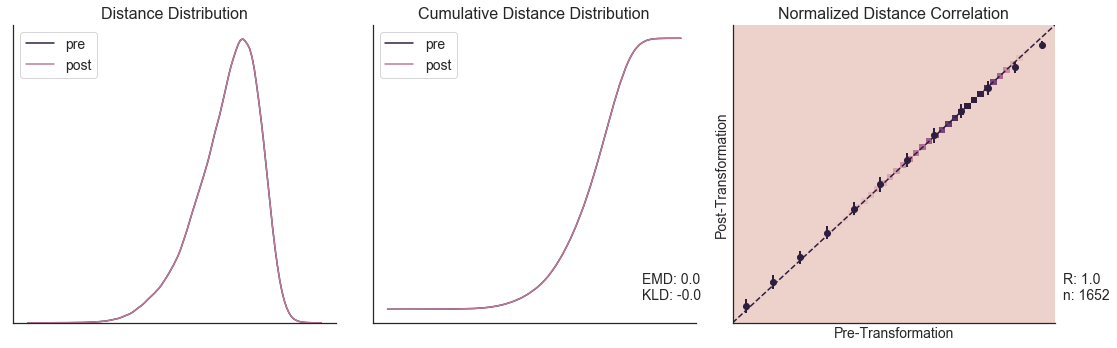

Knn Pres.: 100.0
CPU times: user 1min 20s, sys: 13.2 s, total: 1min 33s
Wall time: 1min 33s


In [180]:
%%time
mantel_stats, EMD, KLD = compare_euclid(pre=retina.distance_matrix(transform='arcsinh'), post=retina_PCA500.distance_matrix())
knn = knn_preservation(pre=retina.knn_graph(k, transform='arcsinh'), post=retina_PCA500.knn_graph(k))
print('Knn Pres.: {}'.format(round(knn, 4)))

Now we can perform a PCA with a smaller number of components and determine the degree of information loss.  
The extreme example would be comparing only the __first two principal components__ to the original dataset:

In [15]:
# create dictionaries for dumping results into
final_distance_stats = {'Retina':{'R':{}, 'EMD':{}, 'KLD':{}, 'Knn Pres.':{}}, 'Colon':{'R':{}, 'EMD':{}, 'KLD':{}, 'Knn Pres.':{}}}

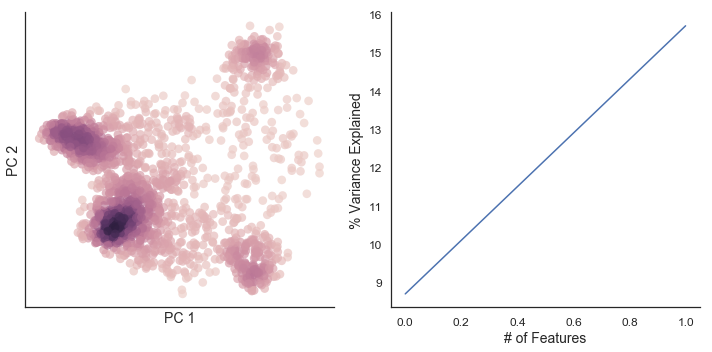

In [7]:
retina_PCA2 = fcc_PCA(retina.arcsinh_norm(), n_components=2)
retina_PCA2.plot_PCA()

In [11]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=retina.distance_matrix(transform='arcsinh'), post=retina_PCA2.distance_matrix())
knn = knn_preservation(pre=retina.knn_graph(k, transform='arcsinh'), post=retina_PCA2.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Retina']['R']['PCA (2)'], final_distance_stats['Retina']['EMD']['PCA (2)'], final_distance_stats['Retina']['KLD']['PCA (2)'], final_distance_stats['Retina']['Knn Pres.']['PCA (2)'] = mantel_stats[0], EMD, KLD, knn

R: 0.55
EMD: 0.3008
KLD: 0.168
Knn Pres.: 97.4598
CPU times: user 1min 7s, sys: 11.4 s, total: 1min 19s
Wall time: 1min 19s


CPU times: user 19.3 s, sys: 510 ms, total: 19.8 s
Wall time: 19.2 s


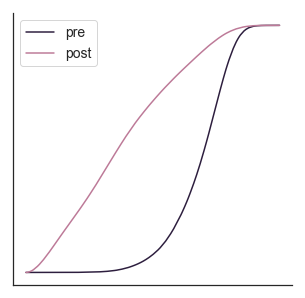

<Figure size 504x504 with 0 Axes>

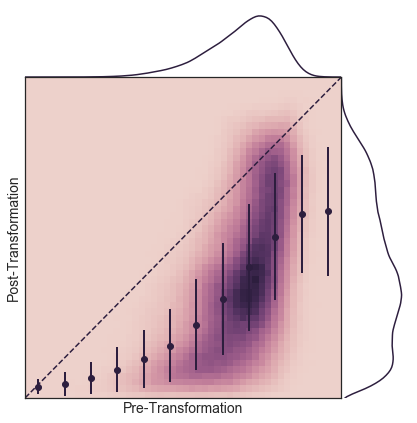

In [12]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/retina_PCA2_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/retina_PCA2_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

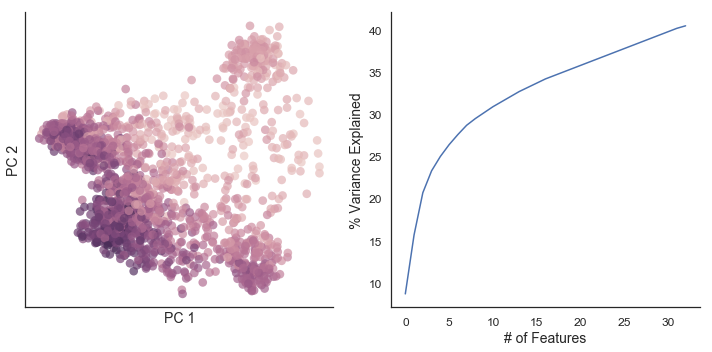

In [13]:
retina_PCA33 = fcc_PCA(retina.arcsinh_norm(), n_components=33)
retina_PCA33.plot_PCA()

In [14]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=retina.distance_matrix(transform='arcsinh'), post=retina_PCA33.distance_matrix())
knn = knn_preservation(pre=retina.knn_graph(k, transform='arcsinh'), post=retina_PCA33.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Retina']['R']['PCA (33)'], final_distance_stats['Retina']['EMD']['PCA (33)'], final_distance_stats['Retina']['KLD']['PCA (33)'], final_distance_stats['Retina']['Knn Pres.']['PCA (33)'] = mantel_stats[0], EMD, KLD, knn

R: 0.745
EMD: 0.1292
KLD: 0.0182
Knn Pres.: 98.0674
CPU times: user 1min 11s, sys: 11.8 s, total: 1min 23s
Wall time: 1min 24s


CPU times: user 18.5 s, sys: 392 ms, total: 18.9 s
Wall time: 18.1 s


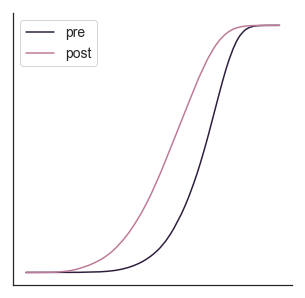

<Figure size 504x504 with 0 Axes>

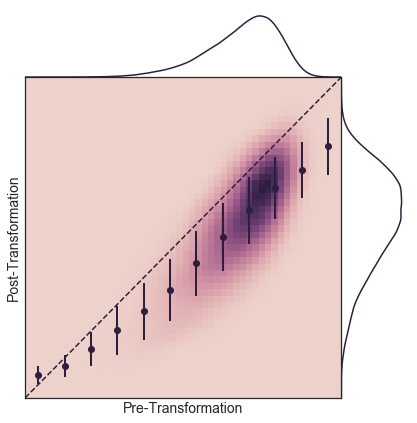

In [15]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/retina_PCA33_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/retina_PCA33_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

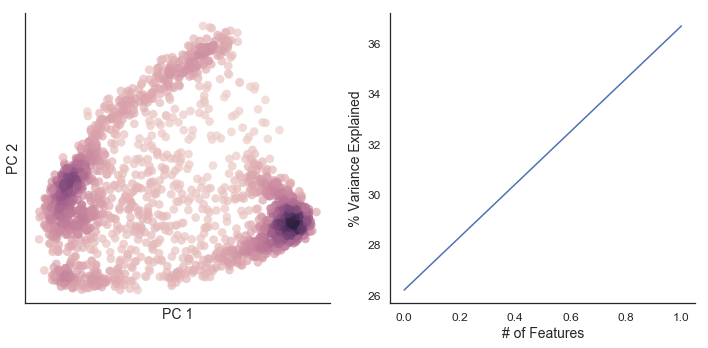

In [184]:
colon_PCA2 = fcc_PCA(colon.arcsinh_norm(), n_components=2)
colon_PCA2.plot_PCA()

In [375]:
colon_PCA2.plot(save_to='images/colon_PCA2.png', figsize=(6,6))

In [318]:
colon_PCA2.plot(color=colon.arcsinh_norm()[:,colon.gene_IDs=='Muc2'].flatten(), save_to='images/colon_Muc2_PCA2.png', figsize=(6,6))

In [319]:
colon_PCA2.plot(color=colon.arcsinh_norm()[:,colon.gene_IDs=='Krt20'].flatten(), save_to='images/colon_Krt20_PCA2.png', figsize=(6,6))

In [320]:
colon_PCA2.plot(color=colon.arcsinh_norm()[:,colon.gene_IDs=='Reg4'].flatten(), save_to='images/colon_Reg4_PCA2.png', figsize=(6,6))

In [185]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=colon.distance_matrix(transform='arcsinh'), post=colon_PCA2.distance_matrix())
knn = knn_preservation(pre=colon.knn_graph(k, transform='arcsinh'), post=colon_PCA2.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Colon']['R']['PCA (2)'], final_distance_stats['Colon']['EMD']['PCA (2)'], final_distance_stats['Colon']['KLD']['PCA (2)'], final_distance_stats['Colon']['Knn Pres.']['PCA (2)'] = mantel_stats[0], EMD, KLD, knn

R: 0.7374
EMD: 0.0872
KLD: 0.1051
Knn Pres.: 97.8163
CPU times: user 1min 8s, sys: 11.4 s, total: 1min 20s
Wall time: 1min 20s


CPU times: user 18.6 s, sys: 476 ms, total: 19.1 s
Wall time: 18.6 s


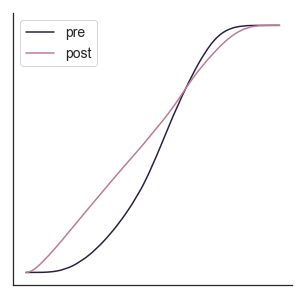

<Figure size 504x504 with 0 Axes>

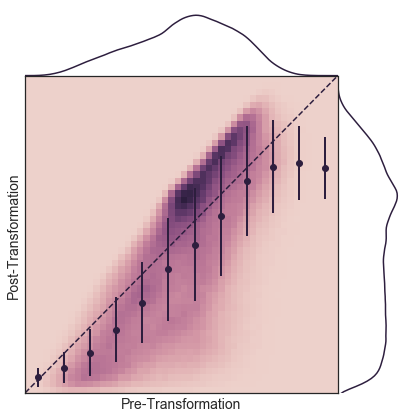

In [186]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/colon_PCA2_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/colon_PCA2_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

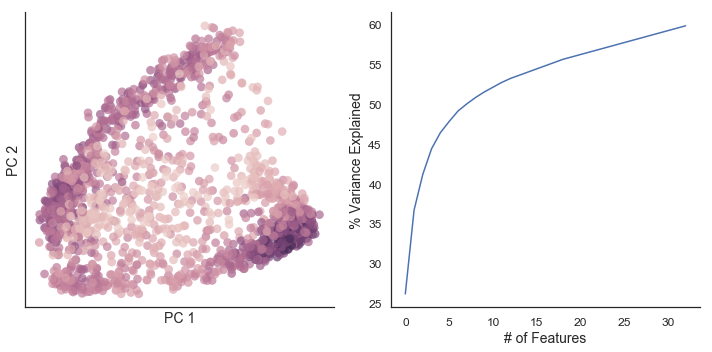

In [16]:
colon_PCA33 = fcc_PCA(colon.arcsinh_norm(), n_components=33)
colon_PCA33.plot_PCA()

In [185]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=colon.distance_matrix(transform='arcsinh'), post=colon_PCA33.distance_matrix())
knn = knn_preservation(pre=colon.knn_graph(k, transform='arcsinh'), post=colon_PCA33.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Colon']['R']['PCA (33)'], final_distance_stats['Colon']['EMD']['PCA (33)'], final_distance_stats['Colon']['KLD']['PCA (33)'], final_distance_stats['Colon']['Knn Pres.']['PCA (33)'] = mantel_stats[0], EMD, KLD, knn

R: 0.7374
EMD: 0.0872
KLD: 0.1051
Knn Pres.: 97.8163
CPU times: user 1min 8s, sys: 11.4 s, total: 1min 20s
Wall time: 1min 20s


CPU times: user 18.6 s, sys: 476 ms, total: 19.1 s
Wall time: 18.6 s


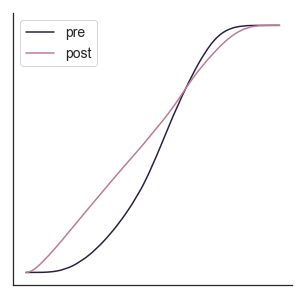

<Figure size 504x504 with 0 Axes>

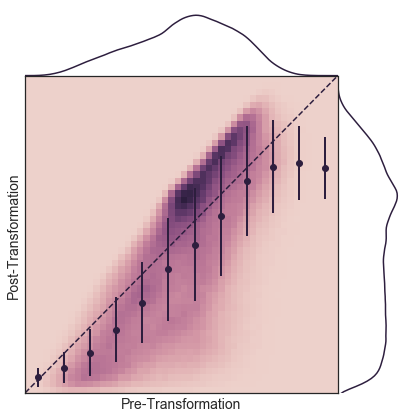

In [186]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/colon_PCA33_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/colon_PCA33_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

---
# t-SNE
A workhorse technique for dimensionality reduction and visualization of scRNA-seq datasets, t-SNE performs a stochastic, non-linear transformation to project high-dimensional data into 2D in order to identify clustering and global structure.  
Here, we will plug arcsinh-normalized counts data directly into t-SNE and compare results to the original, feature-selected dataset.

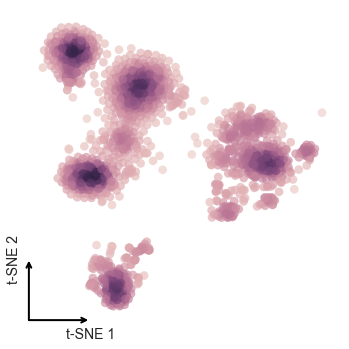

In [21]:
retina_tSNE = fcc_tSNE(retina.arcsinh_norm(), perplexity=30, seed=1)
retina_tSNE.plot()

In [103]:
np.savetxt(X=retina_tSNE.results, fname='dev/pymethods_out/retina_tSNE.csv', delimiter=',')

In [278]:
retina_tSNE.plot(save_to='images/retina_tSNE.png', figsize=(6,6))

In [277]:
retina_tSNE.plot(color=retina.arcsinh_norm()[:,retina.gene_IDs.str.contains('Opn1mw$')].flatten(), save_to='images/retina_Opn1mw_tSNE.png', figsize=(6,6))

In [279]:
retina_tSNE.plot(color=retina.arcsinh_norm()[:,retina.gene_IDs.str.contains('Rlbp1$')].flatten(), save_to='images/retina_Rlbp1_tSNE.png', figsize=(6,6))

In [280]:
retina_tSNE.plot(color=retina.arcsinh_norm()[:,retina.gene_IDs.str.contains('Pax6$')].flatten(), save_to='images/retina_Pax6_tSNE.png', figsize=(6,6))

In [281]:
retina_tSNE.plot(color=retina.arcsinh_norm()[:,retina.gene_IDs.str.contains('Vsx2$')].flatten(), save_to='images/retina_Vsx2_tSNE.png', figsize=(6,6))

In [227]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=retina.distance_matrix(transform='arcsinh'), post=retina_tSNE.distance_matrix())
knn = knn_preservation(pre=retina.knn_graph(k, transform='arcsinh'), post=retina_tSNE.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Retina']['R']['t-SNE'], final_distance_stats['Retina']['EMD']['t-SNE'], final_distance_stats['Retina']['KLD']['t-SNE'], final_distance_stats['Retina']['Knn Pres.']['t-SNE'] = mantel_stats[0], EMD, KLD, knn

R: 0.5266
EMD: 0.2742
KLD: 0.1654
Knn Pres.: 97.294
CPU times: user 1min 8s, sys: 10.6 s, total: 1min 18s
Wall time: 1min 19s


CPU times: user 19 s, sys: 466 ms, total: 19.5 s
Wall time: 18.9 s


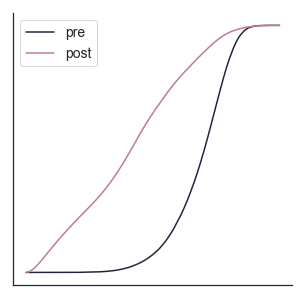

<Figure size 504x504 with 0 Axes>

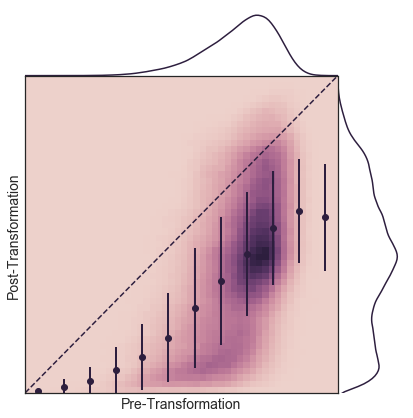

In [228]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/retina_tSNE_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/retina_tSNE_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

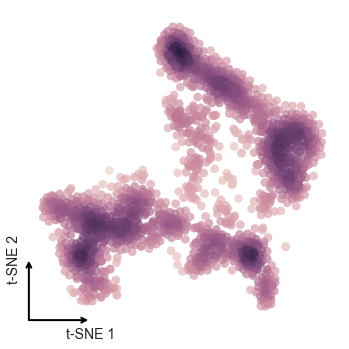

In [24]:
colon_tSNE = fcc_tSNE(colon.arcsinh_norm(), perplexity=30, seed=12)
colon_tSNE.plot()

In [104]:
np.savetxt(X=colon_tSNE.results, fname='dev/pymethods_out/colon_tSNE.csv', delimiter=',')

In [309]:
colon_tSNE.plot(save_to='images/colon_tSNE.png', figsize=(6,6))

In [310]:
colon_tSNE.plot(color=colon.arcsinh_norm()[:,colon.gene_IDs=='Muc2'].flatten(), save_to='images/colon_Muc2_tSNE.png', figsize=(6,6))

In [311]:
colon_tSNE.plot(color=colon.arcsinh_norm()[:,colon.gene_IDs=='Krt20'].flatten(), save_to='images/colon_Krt20_tSNE.png', figsize=(6,6))

In [312]:
colon_tSNE.plot(color=colon.arcsinh_norm()[:,colon.gene_IDs=='Reg4'].flatten(), save_to='images/colon_Reg4_tSNE.png', figsize=(6,6))

In [229]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=colon.distance_matrix(transform='arcsinh'), post=colon_tSNE.distance_matrix())
knn = knn_preservation(pre=colon.knn_graph(k, transform='arcsinh'), post=colon_tSNE.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Colon']['R']['t-SNE'], final_distance_stats['Colon']['EMD']['t-SNE'], final_distance_stats['Colon']['KLD']['t-SNE'], final_distance_stats['Colon']['Knn Pres.']['t-SNE'] = mantel_stats[0], EMD, KLD, knn

R: 0.7469
EMD: 0.1146
KLD: 0.0872
Knn Pres.: 97.6884
CPU times: user 1min 9s, sys: 11 s, total: 1min 20s
Wall time: 1min 21s


CPU times: user 18.5 s, sys: 423 ms, total: 18.9 s
Wall time: 18.3 s


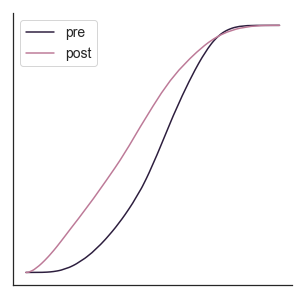

<Figure size 504x504 with 0 Axes>

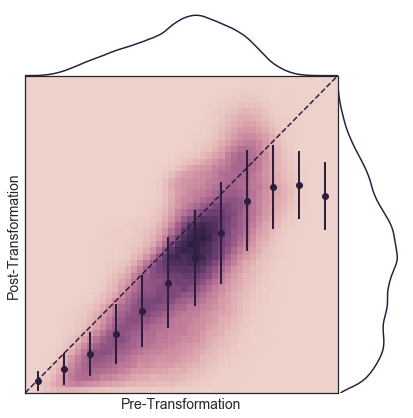

In [230]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/colon_tSNE_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/colon_tSNE_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

---
# UMAP
Another popular method for low-dimensional projection of scRNA-seq datasets, UMAP creates high-dimensional manifolds that describe the structure of the dataset.  
Here, we will plug arcsinh-normalized counts data directly into UMAP and compare results to the original, feature-selected dataset.

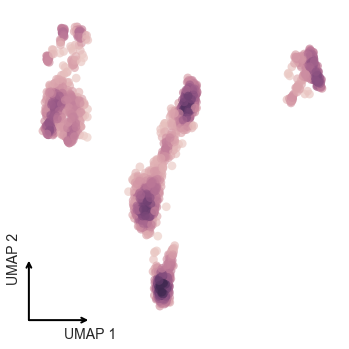

In [30]:
retina_UMAP = fcc_UMAP(retina.arcsinh_norm(), perplexity=30, seed=18)
retina_UMAP.plot()

In [105]:
np.savetxt(X=retina_UMAP.results, fname='dev/pymethods_out/retina_UMAP.csv', delimiter=',')

In [31]:
retina_UMAP.plot(save_to='images/retina_UMAP.png', figsize=(6,6))

In [32]:
retina_UMAP.plot(color=retina.arcsinh_norm()[:,retina.gene_IDs.str.contains('Opn1mw$')].flatten(), save_to='images/retina_Opn1mw_UMAP.png', figsize=(6,6))

In [33]:
retina_UMAP.plot(color=retina.arcsinh_norm()[:,retina.gene_IDs.str.contains('Rlbp1$')].flatten(), save_to='images/retina_Rlbp1_UMAP.png', figsize=(6,6))

In [34]:
retina_UMAP.plot(color=retina.arcsinh_norm()[:,retina.gene_IDs.str.contains('Pax6$')].flatten(), save_to='images/retina_Pax6_UMAP.png', figsize=(6,6))

In [35]:
retina_UMAP.plot(color=retina.arcsinh_norm()[:,retina.gene_IDs.str.contains('Vsx2$')].flatten(), save_to='images/retina_Vsx2_UMAP.png', figsize=(6,6))

In [231]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=retina.distance_matrix(transform='arcsinh'), post=retina_UMAP.distance_matrix())
knn = knn_preservation(pre=retina.knn_graph(k, transform='arcsinh'), post=retina_UMAP.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Retina']['R']['UMAP'], final_distance_stats['Retina']['EMD']['UMAP'], final_distance_stats['Retina']['KLD']['UMAP'], final_distance_stats['Retina']['Knn Pres.']['UMAP'] = mantel_stats[0], EMD, KLD, knn

R: 0.5238
EMD: 0.3376
KLD: 0.2896
Knn Pres.: 97.1521
CPU times: user 1min 7s, sys: 10.3 s, total: 1min 17s
Wall time: 1min 18s


CPU times: user 18.9 s, sys: 421 ms, total: 19.3 s
Wall time: 18.6 s


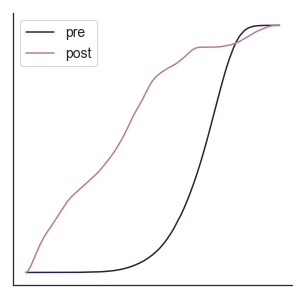

<Figure size 504x504 with 0 Axes>

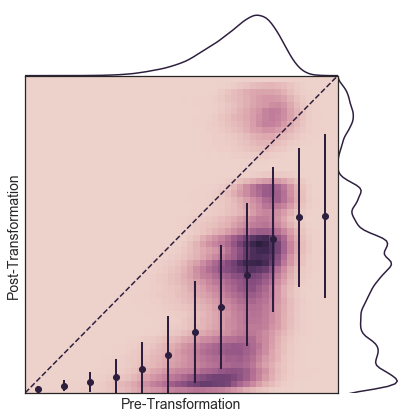

In [232]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/retina_UMAP_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/retina_UMAP_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

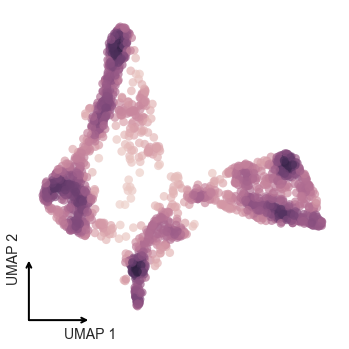

In [38]:
colon_UMAP = fcc_UMAP(colon.arcsinh_norm(), perplexity=30, seed=12)
colon_UMAP.plot()

In [106]:
np.savetxt(X=colon_UMAP.results, fname='dev/pymethods_out/colon_UMAP.csv', delimiter=',')

In [376]:
colon_UMAP.plot(save_to='images/colon_UMAP.png', figsize=(6,6))

In [40]:
colon_UMAP.plot(color=colon.arcsinh_norm()[:,colon.gene_IDs=='Muc2'].flatten(), save_to='images/colon_Muc2_UMAP.png', figsize=(6,6))

In [41]:
colon_UMAP.plot(color=colon.arcsinh_norm()[:,colon.gene_IDs=='Krt20'].flatten(), save_to='images/colon_Krt20_UMAP.png', figsize=(6,6))

In [42]:
colon_UMAP.plot(color=colon.arcsinh_norm()[:,colon.gene_IDs=='Reg4'].flatten(), save_to='images/colon_Reg4_UMAP.png', figsize=(6,6))

In [233]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=colon.distance_matrix(transform='arcsinh'), post=colon_UMAP.distance_matrix())
knn = knn_preservation(pre=colon.knn_graph(k, transform='arcsinh'), post=colon_UMAP.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Colon']['R']['UMAP'], final_distance_stats['Colon']['EMD']['UMAP'], final_distance_stats['Colon']['KLD']['UMAP'], final_distance_stats['Colon']['Knn Pres.']['UMAP'] = mantel_stats[0], EMD, KLD, knn

R: 0.7215
EMD: 0.0977
KLD: 0.1119
Knn Pres.: 97.6149
CPU times: user 1min 8s, sys: 10.9 s, total: 1min 19s
Wall time: 1min 20s


CPU times: user 18.8 s, sys: 482 ms, total: 19.3 s
Wall time: 18.9 s


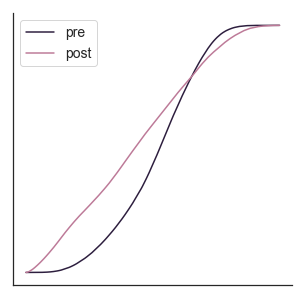

<Figure size 504x504 with 0 Axes>

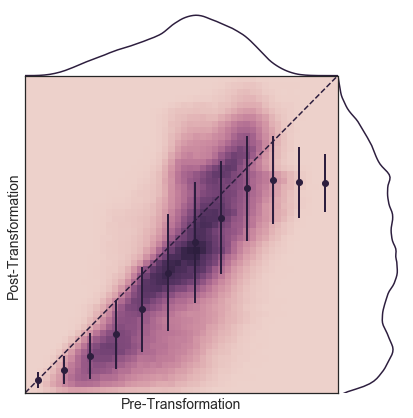

In [234]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/colon_UMAP_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/colon_UMAP_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

---
# ZIFA
This method uses the zero-inflated negative binomial distribution to reduce RNA counts data to lower dimensions.  
Here, we will plug arcsinh-normalized counts data directly into ZIFA and compare results to the original, feature-selected dataset.

Filtering out all genes which are zero in more than 95.0% of samples. To change this, change p0_thresh.
Number of blocks has been set to 1
Running block zero-inflated factor analysis with N = 1652, D = 485, K = 2, n_blocks = 1
Block sizes [485]
Param change below threshold 1.000e-02 after 7 iterations


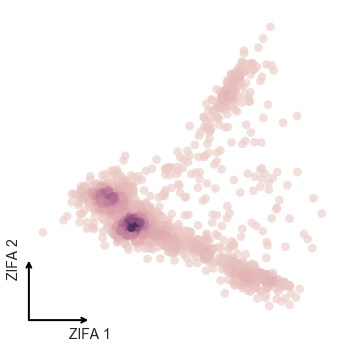

In [46]:
retina_ZIFA = fcc_ZIFA(retina.log2_norm(), K=2)
retina_ZIFA.plot()

In [107]:
np.savetxt(X=retina_ZIFA.results, fname='dev/pymethods_out/retina_ZIFA.csv', delimiter=',')

In [286]:
retina_ZIFA.plot(save_to='images/retina_ZIFA.png', figsize=(6,6))

In [287]:
retina_ZIFA.plot(color=retina.arcsinh_norm()[:,retina.gene_IDs.str.contains('Opn1mw$')].flatten(), save_to='images/retina_Opn1mw_ZIFA.png', figsize=(6,6))

In [288]:
retina_ZIFA.plot(color=retina.arcsinh_norm()[:,retina.gene_IDs.str.contains('Rlbp1$')].flatten(), save_to='images/retina_Rlbp1_ZIFA.png', figsize=(6,6))

In [289]:
retina_ZIFA.plot(color=retina.arcsinh_norm()[:,retina.gene_IDs.str.contains('Pax6$')].flatten(), save_to='images/retina_Pax6_ZIFA.png', figsize=(6,6))

In [290]:
retina_ZIFA.plot(color=retina.arcsinh_norm()[:,retina.gene_IDs.str.contains('Vsx2$')].flatten(), save_to='images/retina_Vsx2_ZIFA.png', figsize=(6,6))

In [235]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=retina.distance_matrix(transform='log2'), post=retina_ZIFA.distance_matrix())
knn = knn_preservation(pre=retina.knn_graph(k, transform='log2'), post=retina_ZIFA.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Retina']['R']['ZIFA'], final_distance_stats['Retina']['EMD']['ZIFA'], final_distance_stats['Retina']['KLD']['ZIFA'], final_distance_stats['Retina']['Knn Pres.']['ZIFA'] = mantel_stats[0], EMD, KLD, knn

R: 0.4392
EMD: 0.1193
KLD: 0.2664
Knn Pres.: 96.8544
CPU times: user 1min 7s, sys: 10.3 s, total: 1min 17s
Wall time: 1min 18s


CPU times: user 18.3 s, sys: 436 ms, total: 18.7 s
Wall time: 18.2 s


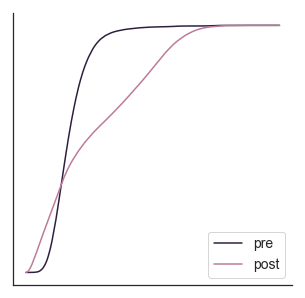

<Figure size 504x504 with 0 Axes>

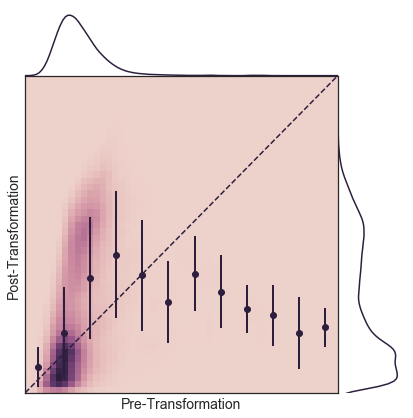

In [236]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/retina_ZIFA_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/retina_ZIFA_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

Filtering out all genes which are zero in more than 95.0% of samples. To change this, change p0_thresh.
Number of blocks has been set to 1
Running block zero-inflated factor analysis with N = 1653, D = 495, K = 2, n_blocks = 1
Block sizes [495]
Param change below threshold 1.000e-02 after 3 iterations


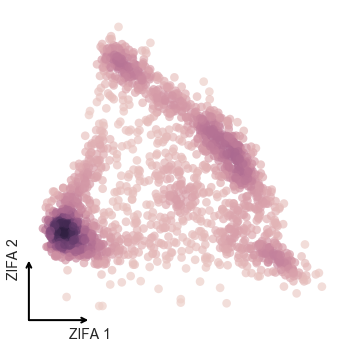

In [49]:
colon_ZIFA = fcc_ZIFA(colon.log2_norm(), K=2)
colon_ZIFA.plot()

In [108]:
np.savetxt(X=colon_ZIFA.results, fname='dev/pymethods_out/colon_ZIFA.csv', delimiter=',')

In [374]:
colon_ZIFA.plot(save_to='images/colon_ZIFA.png', figsize=(6,6))

In [198]:
colon_ZIFA.plot(color=colon.arcsinh_norm()[:,colon.gene_IDs=='Muc2'].flatten(), save_to='images/colon_Muc2_ZIFA.png', figsize=(6,6))

In [199]:
colon_ZIFA.plot(color=colon.arcsinh_norm()[:,colon.gene_IDs=='Krt20'].flatten(), save_to='images/colon_Krt20_ZIFA.png', figsize=(6,6))

In [200]:
colon_ZIFA.plot(color=colon.arcsinh_norm()[:,colon.gene_IDs=='Reg4'].flatten(), save_to='images/colon_Reg4_ZIFA.png', figsize=(6,6))

In [237]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=colon.distance_matrix(transform='log2'), post=colon_ZIFA.distance_matrix())
knn = knn_preservation(pre=colon.knn_graph(k, transform='log2'), post=colon_ZIFA.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Colon']['R']['ZIFA'], final_distance_stats['Colon']['EMD']['ZIFA'], final_distance_stats['Colon']['KLD']['ZIFA'], final_distance_stats['Colon']['Knn Pres.']['ZIFA'] = mantel_stats[0], EMD, KLD, knn

R: 0.5227
EMD: 0.111
KLD: 0.1463
Knn Pres.: 97.1328
CPU times: user 1min 7s, sys: 10.9 s, total: 1min 18s
Wall time: 1min 19s


CPU times: user 19.2 s, sys: 506 ms, total: 19.7 s
Wall time: 19.3 s


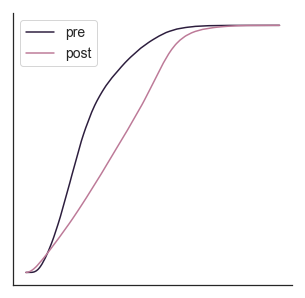

<Figure size 504x504 with 0 Axes>

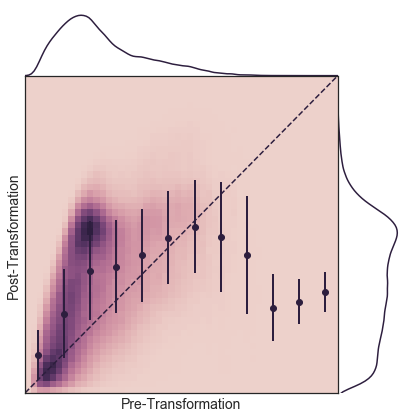

In [238]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/colon_ZIFA_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/colon_ZIFA_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

---
# DCA
This method uses a deep count autoencoder to reduce RNA counts data to lower dimensions.  
Here, we will plug counts data directly into DCA and compare results to the original, feature-selected dataset.

In [5]:
%time retina_DCA = fcc_DCA(retina.counts, n_threads=4, norm=False, seed=18, hidden_size=(64,2,64), mode='latent')

Using TensorFlow backend.
/Users/cody/.virtualenvs/lau_lab/lib/python3.6/site-packages/kopt/config.py:60: YAMLLoadWarning: 
  *** Calling yaml.load() without Loader=... is deprecated.
  *** The default Loader is unsafe.
  *** Please read https://msg.pyyaml.org/load for full details.
  _config = yaml.load(open(_config_path))


DCA: Successfully preprocessed 500 genes and 1652 cells.
Instructions for updating:
Colocations handled automatically by placer.


2019-05-28 17:32:31,873 [WARNING] From /Users/cody/.virtualenvs/lau_lab/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Use tf.cast instead.


2019-05-28 17:32:32,678 [WARNING] From /Users/cody/.virtualenvs/lau_lab/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Calculating low dimensional representations...
Calculating reconstructions...
CPU times: user 1min 11s, sys: 11.4 s, total: 1min 22s
Wall time: 37 s


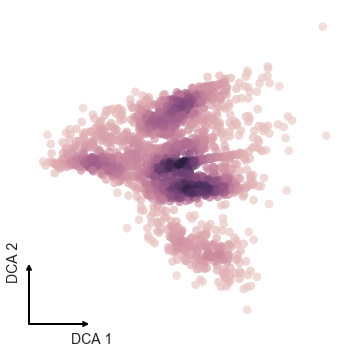

In [6]:
retina_DCA.plot()

In [8]:
np.savetxt(X=retina_DCA.results, fname='dev/pymethods_out/retina_DCA.csv', delimiter=',')

Perform t-SNE on DCA output to visualize

In [10]:
retina_DCA.plot(color=retina.arcsinh_norm()[:,retina.gene_IDs.str.contains('Opn1mw$')].flatten(), save_to='images/retina_Opn1mw_DCA.png', figsize=(6,6))

In [11]:
retina_DCA.plot(color=retina.arcsinh_norm()[:,retina.gene_IDs.str.contains('Rlbp1$')].flatten(), save_to='images/retina_Rlbp1_DCA.png', figsize=(6,6))

In [12]:
retina_DCA.plot(color=retina.arcsinh_norm()[:,retina.gene_IDs.str.contains('Pax6$')].flatten(), save_to='images/retina_Pax6_DCA.png', figsize=(6,6))

In [13]:
retina_DCA.plot(color=retina.arcsinh_norm()[:,retina.gene_IDs.str.contains('Vsx2$')].flatten(), save_to='images/retina_Vsx2_DCA.png', figsize=(6,6))

In [16]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=retina.distance_matrix(transform=None), post=retina_DCA.distance_matrix())
knn = knn_preservation(pre=retina.knn_graph(k, transform=None), post=retina_DCA.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Retina']['R']['DCA'], final_distance_stats['Retina']['EMD']['DCA'], final_distance_stats['Retina']['KLD']['DCA'], final_distance_stats['Retina']['Knn Pres.']['DCA'] = mantel_stats[0], EMD, KLD, knn

R: 0.3402
EMD: 0.1746
KLD: 0.2701
Knn Pres.: 97.1454
CPU times: user 1min 11s, sys: 12.7 s, total: 1min 24s
Wall time: 1min 25s


CPU times: user 18.4 s, sys: 459 ms, total: 18.8 s
Wall time: 18.3 s


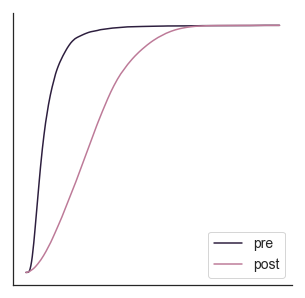

<Figure size 504x504 with 0 Axes>

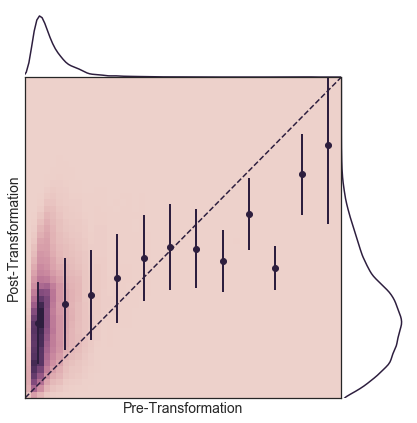

In [17]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/retina_DCA_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/retina_DCA_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

In [19]:
%time colon_DCA = fcc_DCA(colon.counts, n_threads=4, norm=False, seed=18, hidden_size=(64,2,64), mode='latent')

DCA: Successfully preprocessed 500 genes and 1653 cells.
Calculating low dimensional representations...
Calculating reconstructions...
CPU times: user 1min 14s, sys: 12.9 s, total: 1min 27s
Wall time: 37.1 s


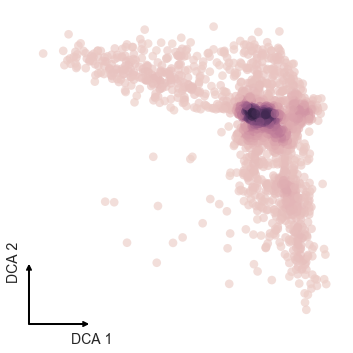

In [20]:
colon_DCA.plot()

In [21]:
np.savetxt(X=colon_DCA.results, fname='dev/pymethods_out/colon_DCA.csv', delimiter=',')

Perform t-SNE on DCA output to visualize

In [22]:
colon_DCA.plot(color=colon.arcsinh_norm()[:,colon.gene_IDs=='Muc2'].flatten(), save_to='images/colon_Muc2_DCA.png', figsize=(6,6))

In [23]:
colon_DCA.plot(color=colon.arcsinh_norm()[:,colon.gene_IDs=='Krt20'].flatten(), save_to='images/colon_Krt20_DCA.png', figsize=(6,6))

In [24]:
colon_DCA.plot(color=colon.arcsinh_norm()[:,colon.gene_IDs=='Reg4'].flatten(), save_to='images/colon_Reg4_DCA.png', figsize=(6,6))

In [25]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=colon.distance_matrix(transform=None), post=colon_DCA.distance_matrix())
knn = knn_preservation(pre=colon.knn_graph(k, transform=None), post=colon_DCA.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Colon']['R']['DCA'], final_distance_stats['Colon']['EMD']['DCA'], final_distance_stats['Colon']['KLD']['DCA'], final_distance_stats['Colon']['Knn Pres.']['DCA'] = mantel_stats[0], EMD, KLD, knn

R: 0.2756
EMD: 0.0942
KLD: 0.3522
Knn Pres.: 97.1486
CPU times: user 1min 10s, sys: 12.1 s, total: 1min 22s
Wall time: 1min 23s


CPU times: user 18.2 s, sys: 382 ms, total: 18.6 s
Wall time: 17.8 s


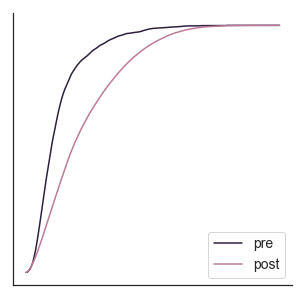

<Figure size 504x504 with 0 Axes>

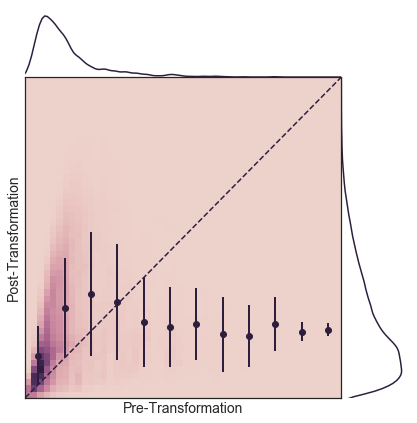

In [26]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/colon_DCA_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/colon_DCA_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

---
# sc-VI
Here, we will plug counts data directly into sc-VI and compare results to the original, feature-selected dataset.

In [111]:
from scvi.dataset import CsvDataset, GeneExpressionDataset
import urllib
from scvi.models import *
from scvi.inference import UnsupervisedTrainer
use_batches=False

In [112]:
# Loading a local dataset into scVI
retina_scVI = CsvDataset('GSM1626793_P14Retina_1.processed.tsv', save_path='inputs/', new_n_genes=500, gene_by_cell=False, sep='\t')

File inputs/GSM1626793_P14Retina_1.processed.tsv already downloaded
Preprocessing dataset
Finished preprocessing dataset


In [113]:
vae = VAE(retina_scVI.nb_genes, n_batch=retina_scVI.n_batches * use_batches)
trainer = UnsupervisedTrainer(vae,
                              retina_scVI,
                              train_size=0.75,
                              use_cuda=True,
                              frequency=5)
trainer.train(n_epochs=400, lr=1e-3)

training: 100%|████████████████████████████████████████████████████████████████████████████████████| 400/400 [02:38<00:00,  2.58it/s]


In [114]:
full = trainer.create_posterior(trainer.model, retina_scVI, indices=np.arange(len(retina_scVI)))
latent, batch_indices, labels = full.sequential().get_latent()
batch_indices = batch_indices.ravel()

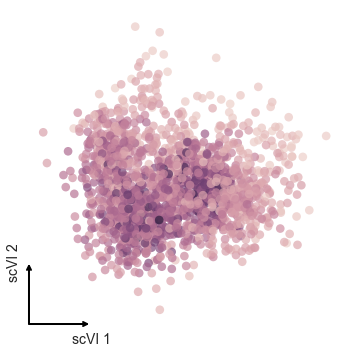

In [117]:
retina_scVI = DR(latent=latent.astype('double'), name='scVI')
retina_scVI.plot()

In [118]:
np.savetxt(X=retina_scVI.results, fname='dev/pymethods_out/retina_scVI.csv', delimiter=',')

Perform t-SNE on scVI output to visualize

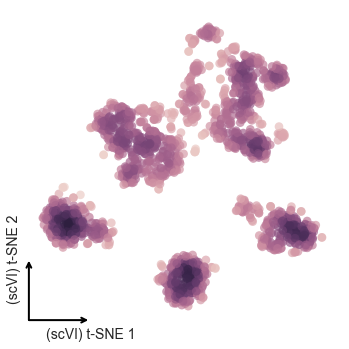

CPU times: user 15.6 s, sys: 148 ms, total: 15.7 s
Wall time: 15.7 s


In [360]:
%%time
retina_scVI_tSNE = fcc_tSNE(retina_scVI.results, perplexity=30, seed=18)
retina_scVI_tSNE.name = '(scVI) t-SNE'
retina_scVI_tSNE.plot()

In [361]:
np.savetxt(X=retina_scVI_tSNE.results, fname='dev/pymethods_out/retina_scVI_tSNE.csv', delimiter=',')

In [362]:
retina_scVI_tSNE.plot(save_to='images/retina_scVI.png', figsize=(6,6))

In [363]:
retina_scVI_tSNE.plot(color=retina.arcsinh_norm()[:,retina.gene_IDs.str.contains('Opn1mw$')].flatten(), save_to='images/retina_Opn1mw_scVI.png', figsize=(6,6))

In [364]:
retina_scVI_tSNE.plot(color=retina.arcsinh_norm()[:,retina.gene_IDs.str.contains('Rlbp1$')].flatten(), save_to='images/retina_Rlbp1_scVI.png', figsize=(6,6))

In [365]:
retina_scVI_tSNE.plot(color=retina.arcsinh_norm()[:,retina.gene_IDs.str.contains('Pax6$')].flatten(), save_to='images/retina_Pax6_scVI.png', figsize=(6,6))

In [366]:
retina_scVI_tSNE.plot(color=retina.arcsinh_norm()[:,retina.gene_IDs.str.contains('Vsx2$')].flatten(), save_to='images/retina_Vsx2_scVI.png', figsize=(6,6))

In [244]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=retina.distance_matrix(transform=None), post=retina_scVI.distance_matrix())
knn = knn_preservation(pre=retina.knn_graph(k, transform=None), post=retina_scVI.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Retina']['R']['scVI'], final_distance_stats['Retina']['EMD']['scVI'], final_distance_stats['Retina']['KLD']['scVI'], final_distance_stats['Retina']['Knn Pres.']['scVI'] = mantel_stats[0], EMD, KLD, knn

R: 0.1911
EMD: 0.3355
KLD: 0.2448
Knn Pres.: 96.8016
CPU times: user 1min 15s, sys: 12.5 s, total: 1min 27s
Wall time: 1min 28s


CPU times: user 18.1 s, sys: 447 ms, total: 18.6 s
Wall time: 17.9 s


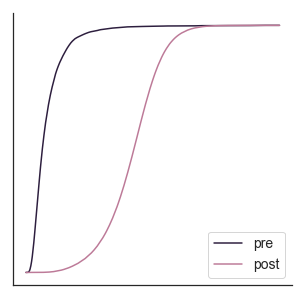

<Figure size 504x504 with 0 Axes>

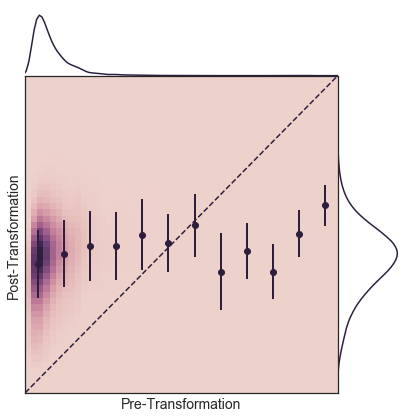

In [245]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/retina_scVI_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/retina_scVI_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

In [121]:
# Loading a local dataset into scVI
colon_scVI = CsvDataset('GSM2743164_rep1_colon_rnaseq.processed.tsv', save_path='inputs/', new_n_genes=500, gene_by_cell=False, sep='\t')

File inputs/GSM2743164_rep1_colon_rnaseq.processed.tsv already downloaded
Preprocessing dataset
Finished preprocessing dataset


In [122]:
vae = VAE(colon_scVI.nb_genes, n_batch=colon_scVI.n_batches * use_batches)
trainer = UnsupervisedTrainer(vae,
                              colon_scVI,
                              train_size=0.75,
                              use_cuda=True,
                              frequency=5)
trainer.train(n_epochs=400, lr=1e-3)

training: 100%|████████████████████████████████████████████████████████████████████████████████████| 400/400 [02:32<00:00,  2.75it/s]


In [123]:
full = trainer.create_posterior(trainer.model, colon_scVI, indices=np.arange(len(colon_scVI)))
latent, batch_indices, labels = full.sequential().get_latent()
batch_indices = batch_indices.ravel()

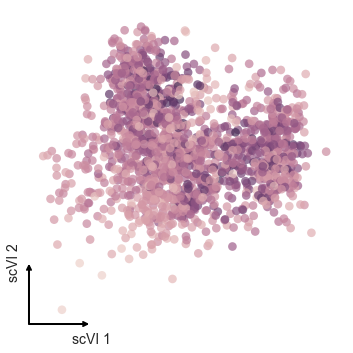

In [124]:
colon_scVI = DR(latent=latent.astype('double'), name='scVI')
colon_scVI.plot()

In [125]:
np.savetxt(X=colon_scVI.results, fname='dev/pymethods_out/colon_scVI.csv', delimiter=',')

Perform t-SNE on scVI output to visualize

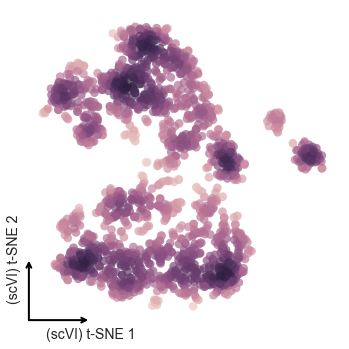

CPU times: user 17.4 s, sys: 93.8 ms, total: 17.5 s
Wall time: 17.4 s


In [367]:
%%time
colon_scVI_tSNE = fcc_tSNE(colon_scVI.results, perplexity=30, seed=18)
colon_scVI_tSNE.name = '(scVI) t-SNE'
colon_scVI_tSNE.plot()

In [368]:
np.savetxt(X=colon_scVI_tSNE.results, fname='dev/pymethods_out/colon_scVI_tSNE.csv', delimiter=',')

In [369]:
colon_scVI_tSNE.plot(save_to='images/colon_scVI.png', figsize=(6,6))

In [370]:
colon_scVI_tSNE.plot(color=colon.arcsinh_norm()[:,colon.gene_IDs=='Muc2'].flatten(), save_to='images/colon_Muc2_scVI.png', figsize=(6,6))

In [371]:
colon_scVI_tSNE.plot(color=colon.arcsinh_norm()[:,colon.gene_IDs=='Krt20'].flatten(), save_to='images/colon_Krt20_scVI.png', figsize=(6,6))

In [372]:
colon_scVI_tSNE.plot(color=colon.arcsinh_norm()[:,colon.gene_IDs=='Reg4'].flatten(), save_to='images/colon_Reg4_scVI.png', figsize=(6,6))

In [246]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=colon.distance_matrix(transform=None), post=colon_scVI.distance_matrix())
knn = knn_preservation(pre=colon.knn_graph(k, transform=None), post=colon_scVI.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Colon']['R']['scVI'], final_distance_stats['Colon']['EMD']['scVI'], final_distance_stats['Colon']['KLD']['scVI'], final_distance_stats['Colon']['Knn Pres.']['scVI'] = mantel_stats[0], EMD, KLD, knn

R: 0.2448
EMD: 0.2835
KLD: 0.2498
Knn Pres.: 97.0162
CPU times: user 1min 15s, sys: 12.5 s, total: 1min 27s
Wall time: 1min 28s


CPU times: user 17.8 s, sys: 345 ms, total: 18.1 s
Wall time: 17.3 s


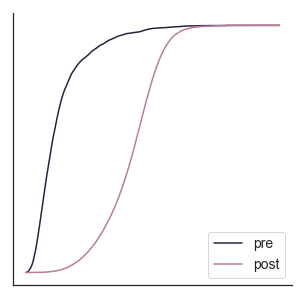

<Figure size 504x504 with 0 Axes>

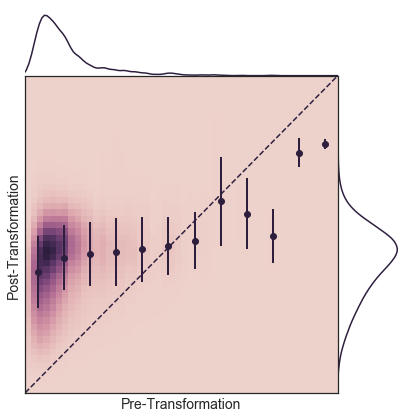

In [247]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/colon_scVI_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/colon_scVI_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

---
# scvis
Here, we will plug counts data directly into scvis and compare results to the original, feature-selected dataset.

In [58]:
retina_scvis = DR.from_file(datafile='dev/scvis_out/retina/perplexity_30_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.tsv',
                            name='scvis')

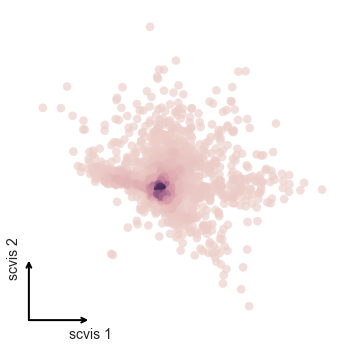

In [59]:
retina_scvis.plot()

In [302]:
retina_scvis.plot(save_to='images/retina_scvis.png', figsize=(6,6))

In [303]:
retina_scvis.plot(color=retina.arcsinh_norm()[:,retina.gene_IDs.str.contains('Opn1mw$')].flatten(), save_to='images/retina_Opn1mw_scvis.png', figsize=(6,6))

In [304]:
retina_scvis.plot(color=retina.arcsinh_norm()[:,retina.gene_IDs.str.contains('Rlbp1$')].flatten(), save_to='images/retina_Rlbp1_scvis.png', figsize=(6,6))

In [305]:
retina_scvis.plot(color=retina.arcsinh_norm()[:,retina.gene_IDs.str.contains('Pax6$')].flatten(), save_to='images/retina_Pax6_scvis.png', figsize=(6,6))

In [306]:
retina_scvis.plot(color=retina.arcsinh_norm()[:,retina.gene_IDs.str.contains('Vsx2$')].flatten(), save_to='images/retina_Vsx2_scvis.png', figsize=(6,6))

In [248]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=retina.distance_matrix(transform=None), post=retina_scvis.distance_matrix())
knn = knn_preservation(pre=retina.knn_graph(k, transform=None), post=retina_scvis.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Retina']['R']['scvis'], final_distance_stats['Retina']['EMD']['scvis'], final_distance_stats['Retina']['KLD']['scvis'], final_distance_stats['Retina']['Knn Pres.']['scvis'] = mantel_stats[0], EMD, KLD, knn

R: 0.7885
EMD: 0.0685
KLD: 0.0771
Knn Pres.: 97.8984
CPU times: user 1min 9s, sys: 10.8 s, total: 1min 20s
Wall time: 1min 20s


CPU times: user 17.6 s, sys: 342 ms, total: 17.9 s
Wall time: 17.1 s


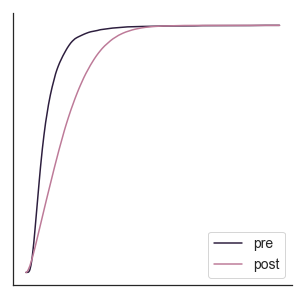

<Figure size 504x504 with 0 Axes>

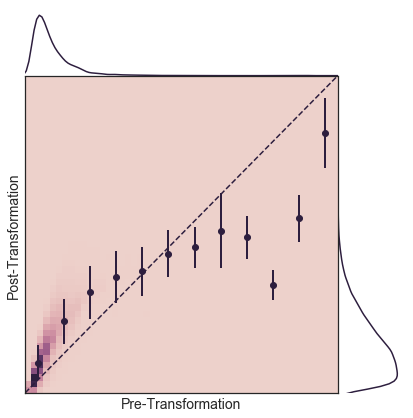

In [249]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/retina_scvis_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/retina_scvis_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

In [62]:
colon_scvis = DR.from_file(datafile='dev/scvis_out/colon/perplexity_30_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.tsv',
                            name='scvis')

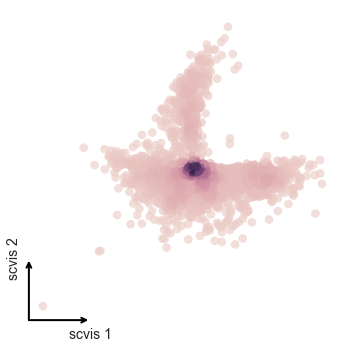

In [63]:
colon_scvis.plot()

In [373]:
colon_scvis.plot(save_to='images/colon_scvis.png', figsize=(6,6))

In [325]:
colon_scvis.plot(color=colon.arcsinh_norm()[:,colon.gene_IDs=='Muc2'].flatten(), save_to='images/colon_Muc2_scvis.png', figsize=(6,6))

In [326]:
colon_scvis.plot(color=colon.arcsinh_norm()[:,colon.gene_IDs=='Krt20'].flatten(), save_to='images/colon_Krt20_scvis.png', figsize=(6,6))

In [327]:
colon_scvis.plot(color=colon.arcsinh_norm()[:,colon.gene_IDs=='Reg4'].flatten(), save_to='images/colon_Reg4_scvis.png', figsize=(6,6))

In [250]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=colon.distance_matrix(transform=None), post=colon_scvis.distance_matrix())
knn = knn_preservation(pre=colon.knn_graph(k, transform=None), post=colon_scvis.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Colon']['R']['scvis'], final_distance_stats['Colon']['EMD']['scvis'], final_distance_stats['Colon']['KLD']['scvis'], final_distance_stats['Colon']['Knn Pres.']['scvis'] = mantel_stats[0], EMD, KLD, knn

R: 0.787
EMD: 0.0595
KLD: 0.0825
Knn Pres.: 98.5684
CPU times: user 1min 9s, sys: 11.8 s, total: 1min 21s
Wall time: 1min 21s


CPU times: user 17.8 s, sys: 361 ms, total: 18.1 s
Wall time: 17.4 s


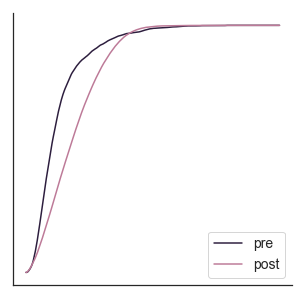

<Figure size 504x504 with 0 Axes>

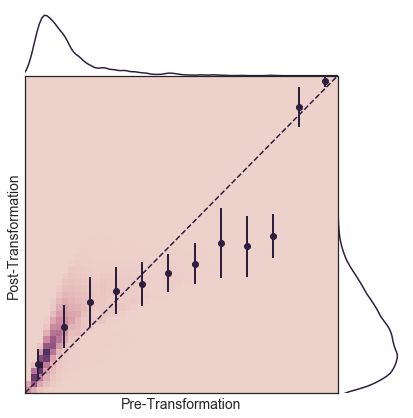

In [251]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/colon_scvis_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/colon_scvis_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

---
# SIMLR
This method builds cell-cell similarity matrices to predict cluster number and assign cells to clusters based on similarity.
First, read in the `F` construct that consists of a c-dimensional output of length `n_cells`, where c is the number of expected clusters passed to SIMLR.  
Here, c was the number of clusters determined by Seurat Louvain algorithm.

In [27]:
retina_SIMLR = DR.from_file('dev/Rmethods_out/retina_SIMLR_F.csv', name='SIMLR', labels=[None,0]) # read in low-dim space for comparison

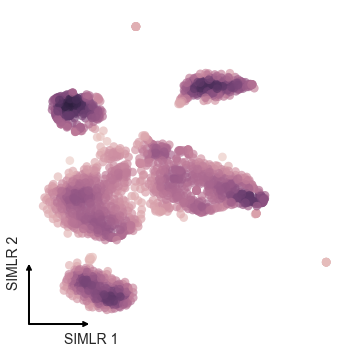

In [29]:
retina_SIMLR.plot()

In [30]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=retina.distance_matrix(transform='arcsinh'), post=retina_SIMLR.distance_matrix())
knn = knn_preservation(pre=retina.knn_graph(k, transform='arcsinh'), post=retina_SIMLR.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Retina']['R']['SIMLR'], final_distance_stats['Retina']['EMD']['SIMLR'], final_distance_stats['Retina']['KLD']['SIMLR'], final_distance_stats['Retina']['Knn Pres.']['SIMLR'] = mantel_stats[0], EMD, KLD, knn

R: 0.2642
EMD: 0.3695
KLD: 0.1868
Knn Pres.: 97.8329
CPU times: user 1min 6s, sys: 9.84 s, total: 1min 16s
Wall time: 1min 17s


CPU times: user 18.8 s, sys: 457 ms, total: 19.3 s
Wall time: 18.6 s


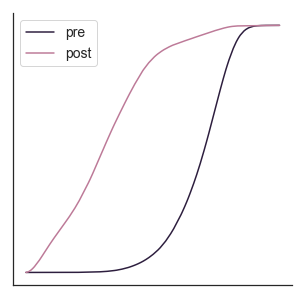

<Figure size 504x504 with 0 Axes>

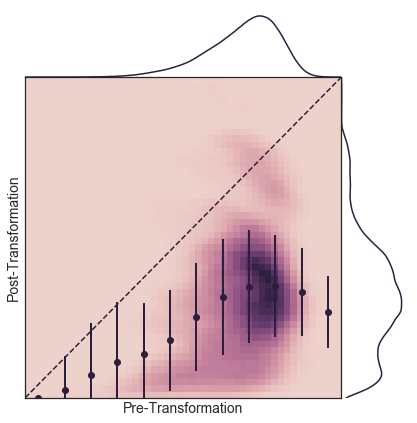

In [31]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/retina_SIMLR_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/retina_SIMLR_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

In [32]:
colon_SIMLR = DR.from_file('dev/Rmethods_out/colon_SIMLR_F.csv', name='SIMLR', labels=[None,0]) # read in low-dim space for comparison

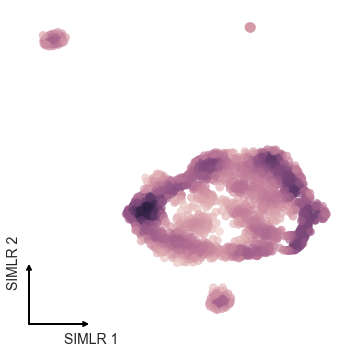

In [33]:
colon_SIMLR.plot()

In [34]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=colon.distance_matrix(transform='arcsinh'), post=colon_SIMLR.distance_matrix())
knn = knn_preservation(pre=colon.knn_graph(k, transform='arcsinh'), post=colon_SIMLR.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Colon']['R']['SIMLR'], final_distance_stats['Colon']['EMD']['SIMLR'], final_distance_stats['Colon']['KLD']['SIMLR'], final_distance_stats['Colon']['Knn Pres.']['SIMLR'] = mantel_stats[0], EMD, KLD, knn

R: 0.5276
EMD: 0.2642
KLD: 0.1374
Knn Pres.: 97.7256
CPU times: user 1min 5s, sys: 10.5 s, total: 1min 16s
Wall time: 1min 16s


CPU times: user 20.4 s, sys: 725 ms, total: 21.1 s
Wall time: 20.8 s


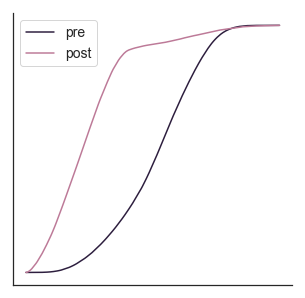

<Figure size 504x504 with 0 Axes>

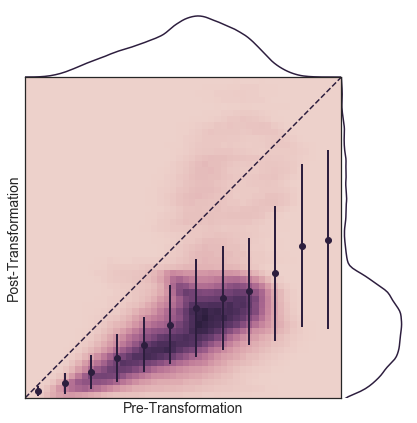

In [35]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/colon_SIMLR_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/colon_SIMLR_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

---
### ZINB-WAVE

In [36]:
retina_ZINBWAVE = DR.from_file('dev/Rmethods_out/retina_ZINB-WAVE.csv', name='ZINB-WaVE', labels=[None,0])

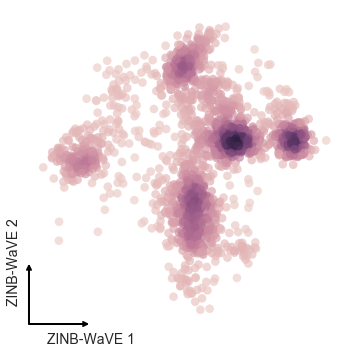

In [37]:
retina_ZINBWAVE.plot()

In [38]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=retina.distance_matrix(transform=None), post=retina_ZINBWAVE.distance_matrix())
knn = knn_preservation(pre=retina.knn_graph(k, transform=None), post=retina_ZINBWAVE.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Retina']['R']['ZINB-WaVE'], final_distance_stats['Retina']['EMD']['ZINB-WaVE'], final_distance_stats['Retina']['KLD']['ZINB-WaVE'], final_distance_stats['Retina']['Knn Pres.']['ZINB-WaVE'] = mantel_stats[0], EMD, KLD, knn

R: 0.2157
EMD: 0.2616
KLD: 0.3344
Knn Pres.: 96.7389
CPU times: user 1min 9s, sys: 11 s, total: 1min 20s
Wall time: 1min 20s


CPU times: user 20 s, sys: 434 ms, total: 20.4 s
Wall time: 20 s


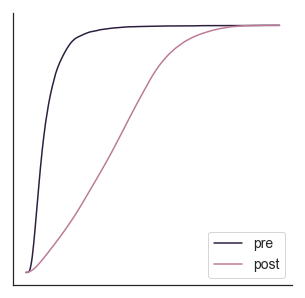

<Figure size 504x504 with 0 Axes>

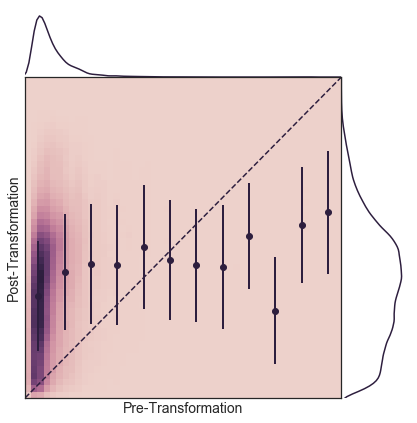

In [39]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/retina_ZINBWAVE_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/retina_ZINBWAVE_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

In [40]:
colon_ZINBWAVE = DR.from_file('dev/Rmethods_out/colon_ZINB-WAVE.csv', name='ZINB-WaVE', labels=[None,0])

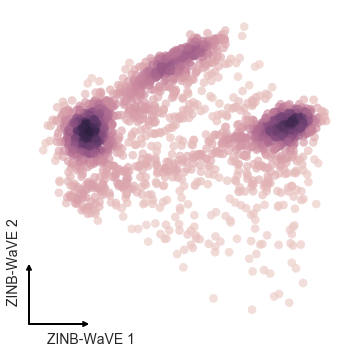

In [41]:
colon_ZINBWAVE.plot()

In [42]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=colon.distance_matrix(transform=None), post=colon_ZINBWAVE.distance_matrix())
knn = knn_preservation(pre=colon.knn_graph(k, transform=None), post=colon_ZINBWAVE.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Colon']['R']['ZINB-WaVE'], final_distance_stats['Colon']['EMD']['ZINB-WaVE'], final_distance_stats['Colon']['KLD']['ZINB-WaVE'], final_distance_stats['Colon']['Knn Pres.']['ZINB-WaVE'] = mantel_stats[0], EMD, KLD, knn

R: 0.228
EMD: 0.2314
KLD: 0.3266
Knn Pres.: 96.9482
CPU times: user 1min 7s, sys: 10.2 s, total: 1min 17s
Wall time: 1min 18s


CPU times: user 18.6 s, sys: 427 ms, total: 19.1 s
Wall time: 18.4 s


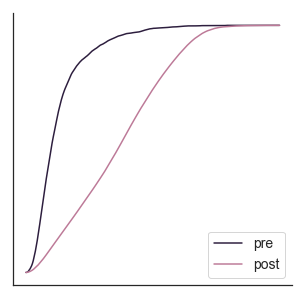

<Figure size 504x504 with 0 Axes>

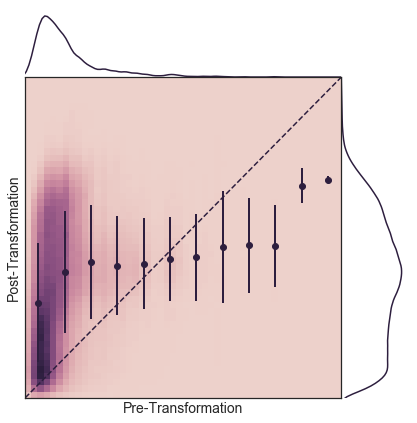

In [43]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/colon_ZINBWAVE_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/colon_ZINBWAVE_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

---
### GLM-PCA

In [44]:
retina_GLMPCA = DR.from_file('dev/Rmethods_out/retina_GLM-PCA.csv', name='GLM-PC', labels=[None,0])

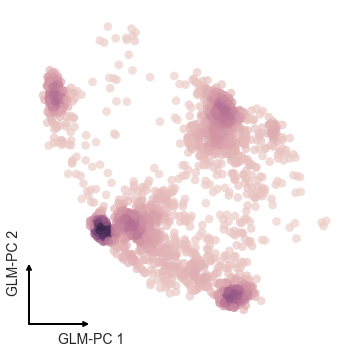

In [45]:
retina_GLMPCA.plot()

In [46]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=retina.distance_matrix(transform=None), post=retina_GLMPCA.distance_matrix())
knn = knn_preservation(pre=retina.knn_graph(k, transform=None), post=retina_GLMPCA.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Retina']['R']['GLM-PCA'], final_distance_stats['Retina']['EMD']['GLM-PCA'], final_distance_stats['Retina']['KLD']['GLM-PCA'], final_distance_stats['Retina']['Knn Pres.']['GLM-PCA'] = mantel_stats[0], EMD, KLD, knn

R: 0.1808
EMD: 0.2659
KLD: 0.375
Knn Pres.: 96.7162
CPU times: user 1min 8s, sys: 10.1 s, total: 1min 18s
Wall time: 1min 18s


CPU times: user 18.5 s, sys: 462 ms, total: 19 s
Wall time: 18.4 s


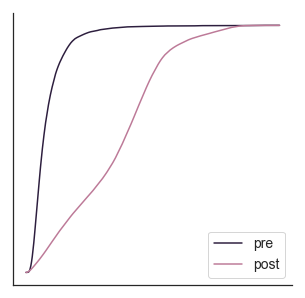

<Figure size 504x504 with 0 Axes>

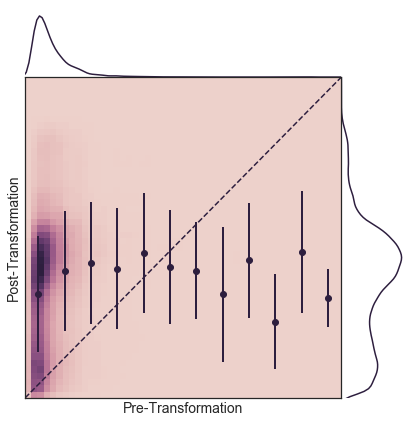

In [47]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/retina_GLMPCA_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/retina_GLMPCA_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

In [48]:
colon_GLMPCA = DR.from_file('dev/Rmethods_out/colon_GLM-PCA.csv', name='GLM-PC', labels=[None,0])

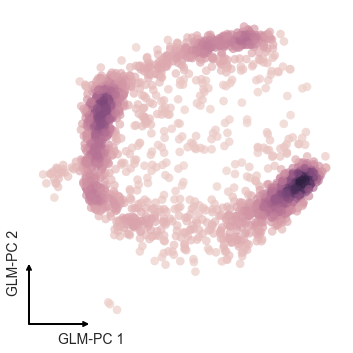

In [49]:
colon_GLMPCA.plot()

In [50]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=colon.distance_matrix(transform=None), post=colon_GLMPCA.distance_matrix())
knn = knn_preservation(pre=colon.knn_graph(k, transform=None), post=colon_GLMPCA.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Colon']['R']['GLM-PCA'], final_distance_stats['Colon']['EMD']['GLM-PCA'], final_distance_stats['Colon']['KLD']['GLM-PCA'], final_distance_stats['Colon']['Knn Pres.']['GLM-PCA'] = mantel_stats[0], EMD, KLD, knn

R: 0.285
EMD: 0.2823
KLD: 0.3106
Knn Pres.: 96.9455
CPU times: user 1min 8s, sys: 10.6 s, total: 1min 19s
Wall time: 1min 19s


CPU times: user 18.3 s, sys: 398 ms, total: 18.7 s
Wall time: 17.9 s


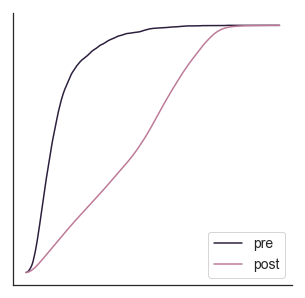

<Figure size 504x504 with 0 Axes>

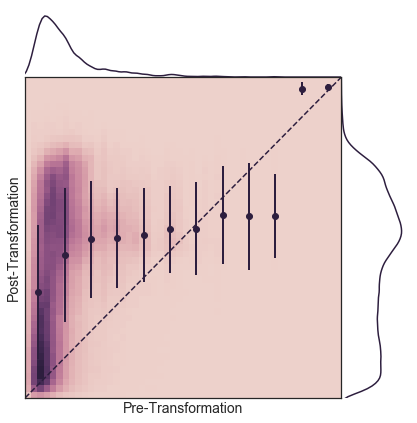

In [51]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/colon_GLMPCA_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/colon_GLMPCA_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

---
### Summary Metrics

In [156]:
retina_sum = pd.DataFrame(final_distance_stats['Retina'])

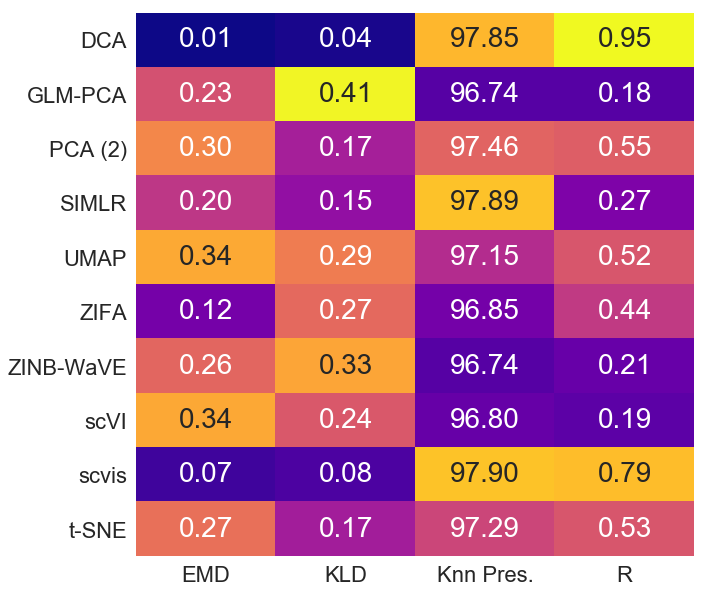

In [157]:
retina_norm=(retina_sum-retina_sum.mean())/retina_sum.std()
sns.set(font_scale=2)
plt.figure(figsize=(10,10))
sns.heatmap(retina_norm, annot=retina_sum, cmap='plasma', robust=True, annot_kws={"size": 28}, fmt='.2f', cbar=False)

In [158]:
colon_sum = pd.DataFrame(final_distance_stats['Colon'])

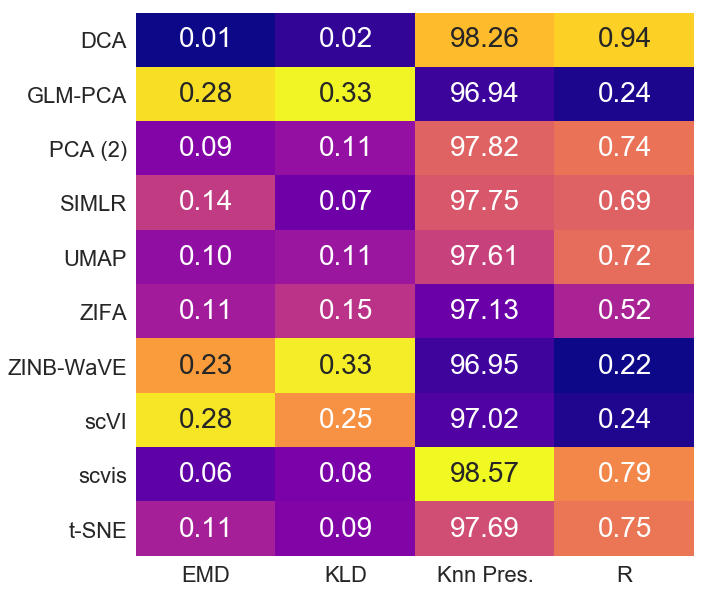

In [159]:
colon_norm=(colon_sum-colon_sum.mean())/colon_sum.std()
sns.set(font_scale=2)
plt.figure(figsize=(10,10))
sns.heatmap(colon_norm, annot=colon_sum, cmap='plasma', robust=True, annot_kws={"size": 28}, fmt='.2f', cbar=False)